In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.profile_performance as profile_performance
import model.train_profile_model as train_profile_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm

### Define paths for the model and data of interest

In [7]:
# Define the paths to the files and model, and some constants
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE/profile/config/SPI1/SPI1_training_paths.json"

reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

motif_pred_bigwig_path = "/users/amtseng/test/genomewide_motif_preds/homer_spi1_preds.bw"

In [3]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
profile_hdf5 = files_spec["profile_hdf5"]

In [4]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Import the model without priors
noprior_model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1/1/model_ckpt_epoch_1.pt"
noprior_model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, noprior_model_path)
noprior_model.eval()
noprior_model = noprior_model.to(device) 

In [6]:
# Import the model without priors
prior_model_path = "/users/amtseng/att_priors/models/trained_models/profile_models/SPI1_motifpredprior_attdecay/1/model_ckpt_epoch_1.pt"
prior_model = model_util.restore_model(profile_models.ProfileTFBindingPredictor, prior_model_path)
prior_model.eval()
prior_model = prior_model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [16]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles
coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, motif_pred_bigwig_path, profile_length, input_length)

# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs, motif_preds = coords_to_vals(coords)
    return input_seq, np.swapaxes(profs, 1, 2), motif_preds

### Predicting and plotting profiles

In [9]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

In [22]:
def compute_losses(model, coords, att_prior_pos_limit=160):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles, motif_preds = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()
    motif_preds = model_util.place_tensor(torch.tensor(motif_preds)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss), (pos_loss, neg_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, status, input_grads, motif_preds,
            0, 0, 1, 0, att_prior_pos_limit, None, 0, 3, False
    )
    return prof_loss.item(), count_loss.item(), pos_loss.item(), neg_loss.item()

In [21]:
def predict_coords(model, coords, att_prior_pos_limit=160):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions, the true values from the dataset, and
    the input gradients. The returned profiles are in terms of raw counts, and the
    returned counts are also raw. Returned values are all NumPy arrays.
    """
    input_seqs, profiles, motif_preds = coords_to_network_inputs(coords)
    
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs)).float()
    profiles = model_util.place_tensor(torch.tensor(profiles)).float()
    motif_preds = model_util.place_tensor(torch.tensor(motif_preds)).float()

    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    logit_pred_profs, log_pred_counts = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        logit_pred_profs, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(logit_pred_profs.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    input_seqs_np = input_seqs.detach().cpu().numpy()
    
    input_grads = input_grads * input_seqs
    
    status = model_util.place_tensor(torch.ones(input_seqs.size()[0]))
    loss, (corr_loss, att_loss), (prof_loss, count_loss), (pos_loss, neg_loss) = \
        train_profile_model.model_loss(
            model, true_profs, logit_pred_profs, log_pred_counts, status, input_grads, motif_preds,
            0, 0, 1, 0, att_prior_pos_limit, None, 0, 3, False
    )
    print("Profile loss\tCounts loss\t+ prior loss \t-prior loss")
    print("%6.3f\t%6.3f\t%6.3f\t%6.3f" % (
        prof_loss.item(), count_loss.item(), pos_loss.item(), neg_loss.item(),
    ))
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs, axis=2)
    
    # Add true profiles to get true counts
    true_counts = torch.sum(true_profs, dim=2)
    
    # Truncate input gradients to profile length
    left = int((input_seqs.shape[1] - profile_length) / 2)
    right = left + profile_length
    input_grads = input_grads[:, left:right, :]
    
    return log_pred_profs.detach().cpu().numpy(), log_pred_counts.detach().cpu().numpy(), true_profs.cpu().numpy(), true_counts.cpu().numpy(), input_seqs_np, input_grads_np

In [12]:
def plot_profiles(pred_profs, true_profs, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    fig, ax = plt.subplots(num_tasks, figsize=(15, num_tasks * 4))
    if num_tasks == 1:
        ax = [ax]
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### Computing/plotting Fourier transforms

In [13]:
def dft(signal):
    fourier_coeffs = np.fft.fft(signal)
    fourier_freqs = 2 * np.pi * np.fft.fftfreq(signal.size)
    fourier_freqs = fourier_freqs[:int(len(fourier_freqs) / 2)]  # Only the positive frequencies
    mags = np.abs(fourier_coeffs)[:int(len(fourier_coeffs) / 2)]  # Frequency magnitudes are symmetric
    return fourier_freqs, mags

In [14]:
def plot_grad_and_fft(input_grad, input_seq, include_dc=False, pos_limit=None):
    assert len(input_grad.shape) == 2
    assert len(input_seq.shape) == 2
    
    grad_x_seq = np.sum(input_grad * input_seq, axis=1)
    abs_grad = np.abs(grad_x_seq)
    freqs, mags = dft(abs_grad)
    
    if not include_dc:
        freqs, mags = freqs[1:], mags[1:]
    
    # Plot the original signal, absolute value, and the DFT
    fig, ax = plt.subplots(3, 1, figsize=(20, 10))
    ax[0].plot(grad_x_seq)
    ax[0].set_title("Input gradient * input sequence")
    ax[0].margins(0)
    ax[1].plot(abs_grad)
    ax[1].set_title("|Input gradient * input sequence|")
    ax[1].margins(0)
    ax[2].plot(freqs, mags, color="red")
    ax[2].set_xlabel("Frequency (radians)")
    ax[2].set_ylabel("|Frequency component|")
    if pos_limit is not None:
        pos_limit_radians = pos_limit * 2 * np.pi / len(grad_x_seq)
        ax[2].axvline(x=pos_limit_radians, color="black")
    ax[2].margins(0)
    fig.tight_layout()

### View predictions

In [23]:
coords, noprior_losses, prior_losses = [], [], []
sample = pos_coords_table[pos_coords_table[0].isin(["chr8", "chr10"])].sample(500).values[:, :3]
for row in tqdm.tqdm(sample):
    chrom, start, end = row
    noprior_losses.append(compute_losses(noprior_model, [(chrom, start, end)], att_prior_pos_limit=160)[0])
    prior_losses.append(compute_losses(prior_model, [(chrom, start, end)], att_prior_pos_limit=160)[0])
    coords.append((chrom, start, end))

100%|██████████| 500/500 [00:25<00:00, 19.35it/s]


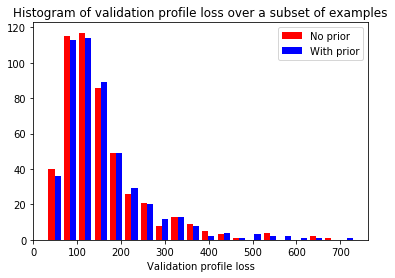

In [24]:
bin_num = 20
plt.figure()
plt.hist(
    [noprior_losses, prior_losses],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
plt.title("Histogram of validation profile loss over a subset of examples")
plt.xlabel("Validation profile loss")
plt.legend()

Text(0.5, 0, 'Validation profile loss without priors minus validation profile loss with priors')

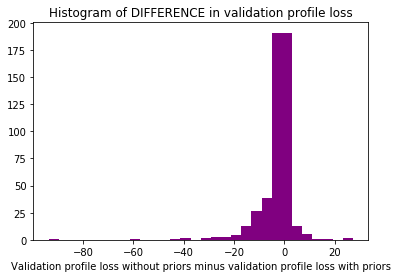

In [25]:
diffs = np.array(noprior_losses) - np.array(prior_losses)
bin_num = 30
plt.figure()
plt.hist(diffs, bin_num, histtype="bar", color="purple")
plt.title("Histogram of DIFFERENCE in validation profile loss")
plt.xlabel("Validation profile loss without priors minus validation profile loss with priors")

In [17]:
worst_inds = np.argsort(diffs)[:10]
print(diffs[worst_inds])
for c in np.array(coords)[worst_inds]:
    print(", ".join(c))

[-35.88171387 -35.74047852 -31.87936401 -31.22731018 -26.74645996
 -23.47259521 -18.77177429 -18.18725586 -17.3085022  -17.12979126]
chr8, 76599723, 76599916
chr8, 81001549, 81001766
chr8, 118499246, 118499551
chr10, 71873725, 71873886
chr8, 127422302, 127422470
chr10, 14742873, 14743095
chr10, 43126780, 43127064
chr10, 99685711, 99685965
chr8, 22975316, 22975664
chr8, 37737654, 37737851


In [21]:
coords[1]

('chr8', 127567478, 127567762)

In [26]:
def predict_and_plot(model, chrom, start, end):
    log_pred_profs, log_pred_counts, true_profs, true_counts, input_seqs, input_grads = \
        predict_coords(model, [(chrom, start, end)] * 50, att_prior_pos_limit=160)

    pred_prof_probs = np.exp(log_pred_profs)
    true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)
    plot_profiles(pred_prof_probs[0], true_prof_probs[0])

    plot_grad_and_fft(input_grads[0], input_seqs[0], pos_limit=160)
    slc = slice(600, 700)
    viz_sequence.plot_weights(input_grads[0][slc])
    viz_sequence.plot_weights((input_grads[0] * input_seqs[0])[slc])

Profile loss	Counts loss	+ prior loss 	-prior loss
108.233	 0.414	 1.000	 1.000


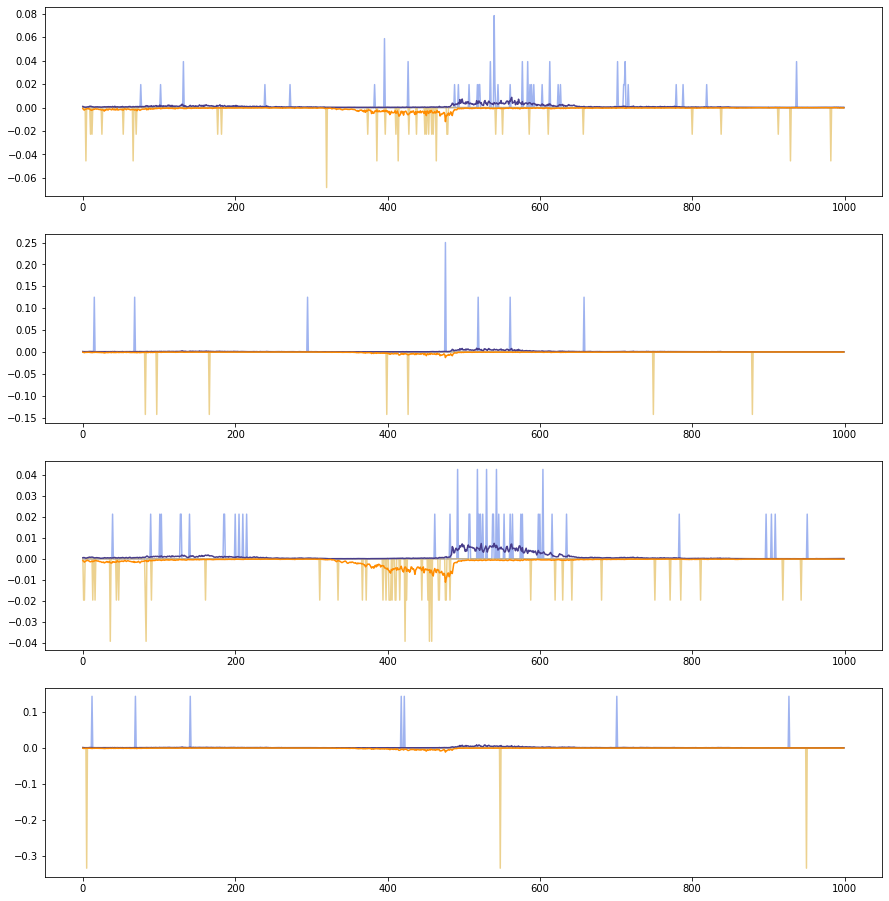

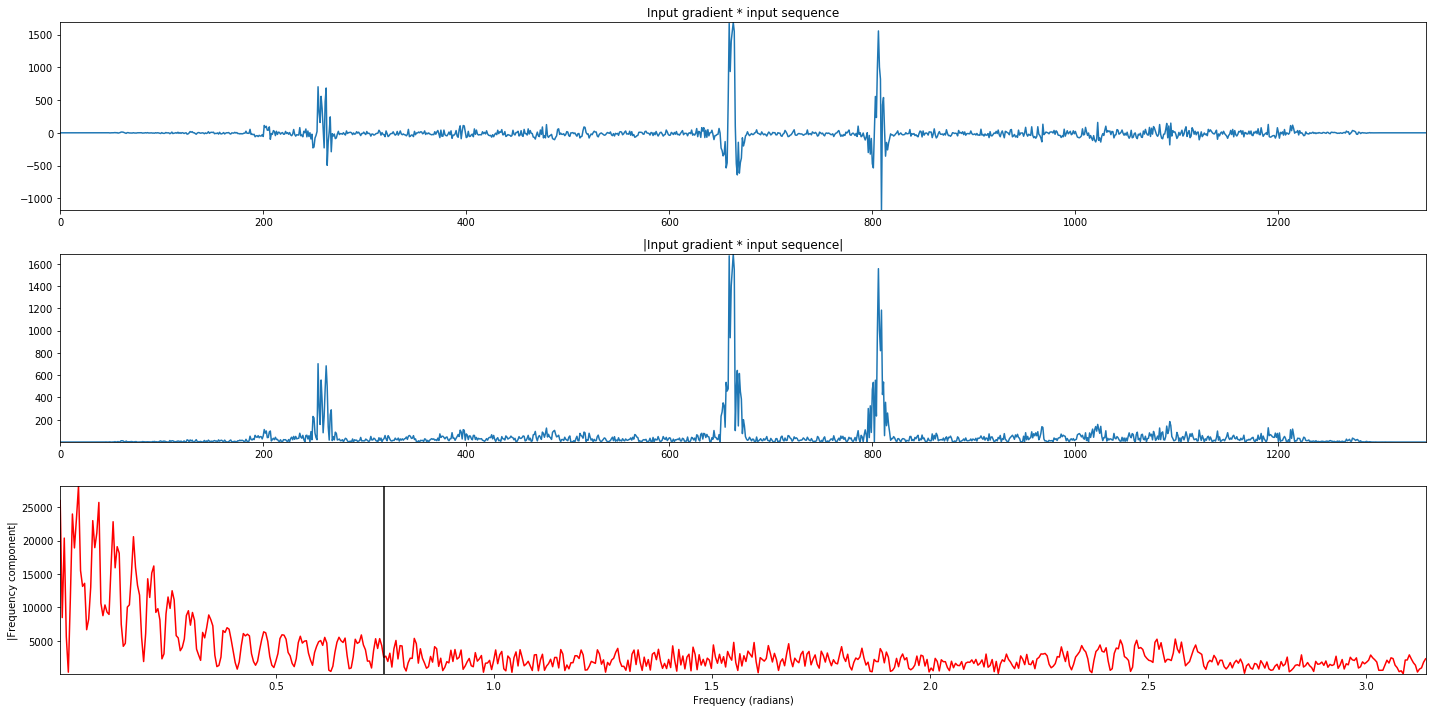

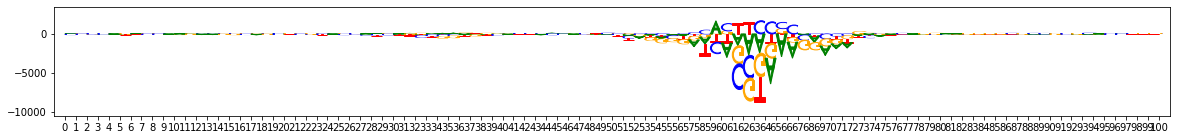

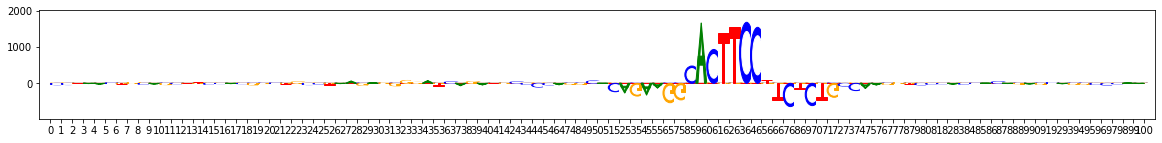

Profile loss	Counts loss	+ prior loss 	-prior loss
107.850	 0.224	 1.000	 1.000


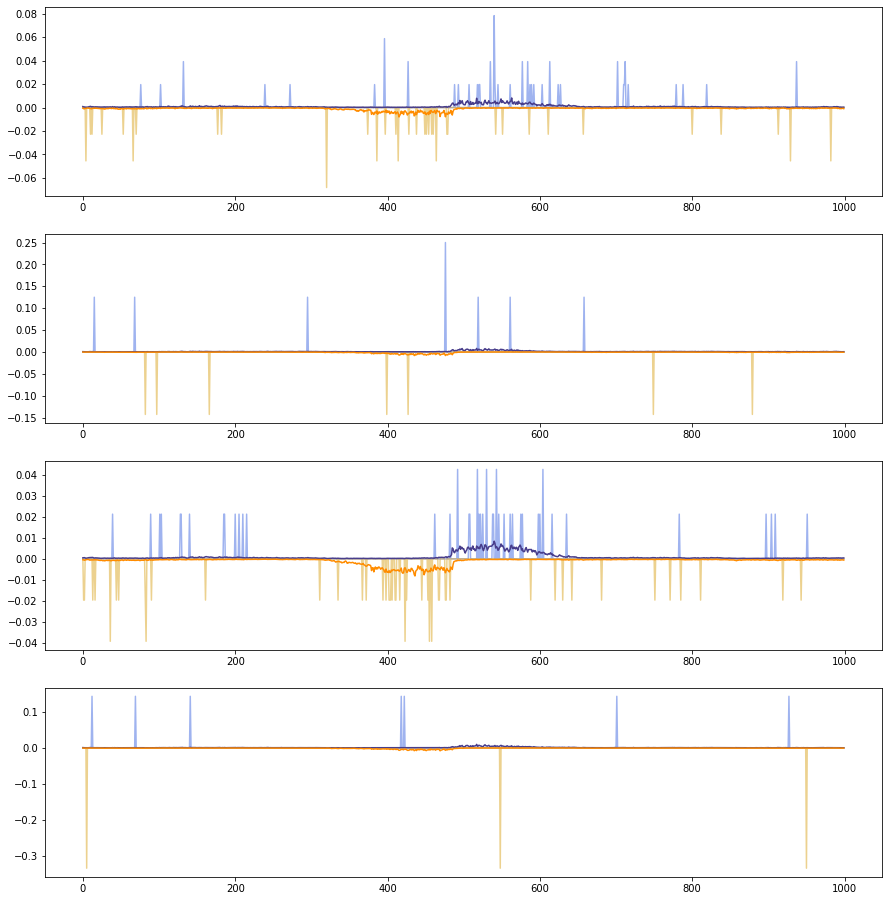

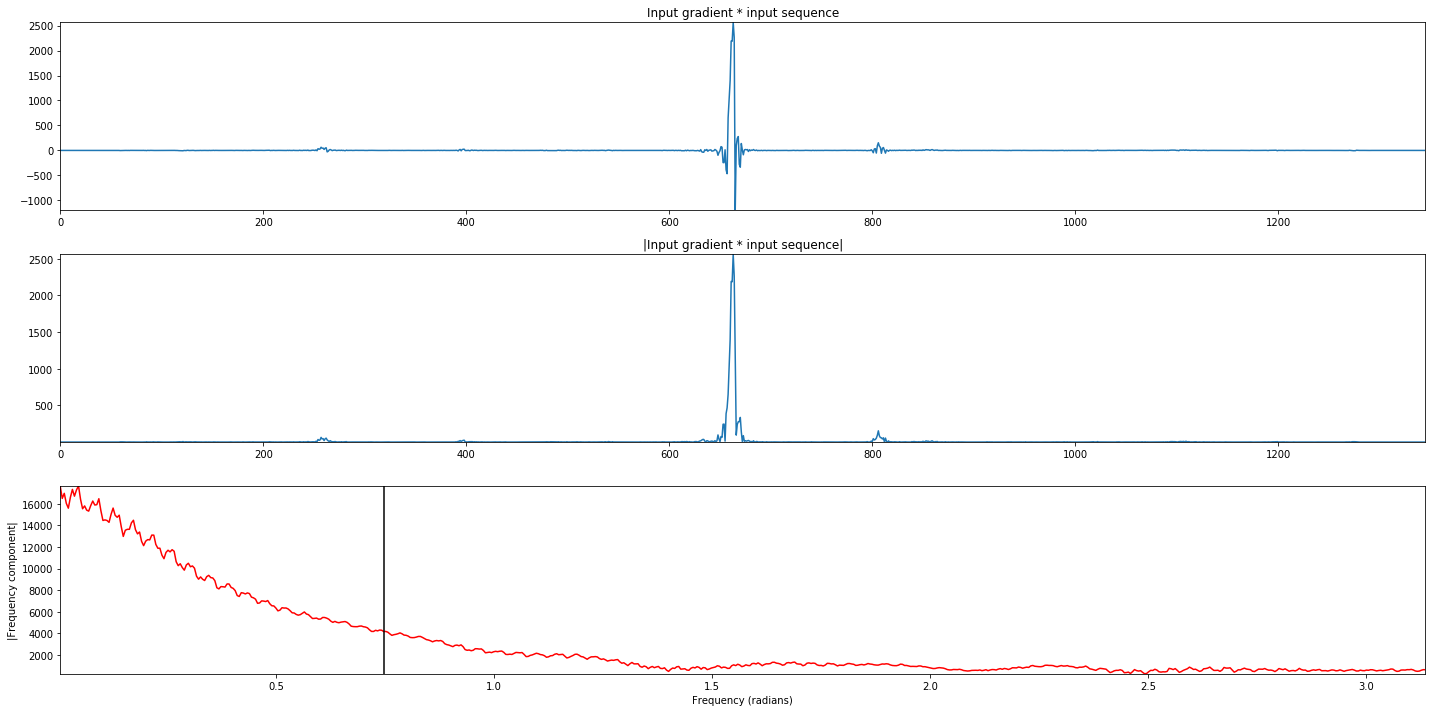

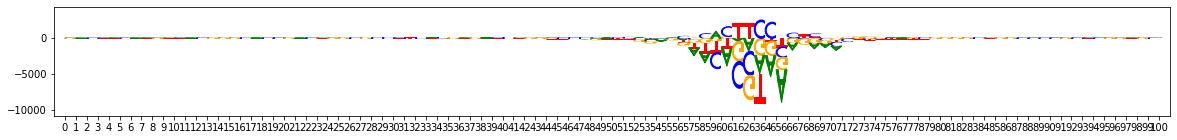

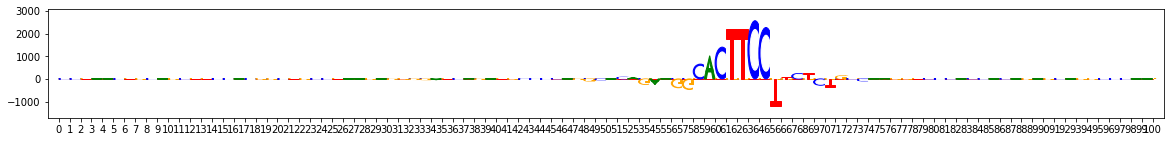

In [27]:
chrom, start, end = "chr8", 127567478, 127567762
predict_and_plot(noprior_model, chrom, start, end)
predict_and_plot(prior_model, chrom, start, end)

Profile loss	Counts loss	+ prior loss 	-prior loss
411.005	 2.416	 0.793	 0.793


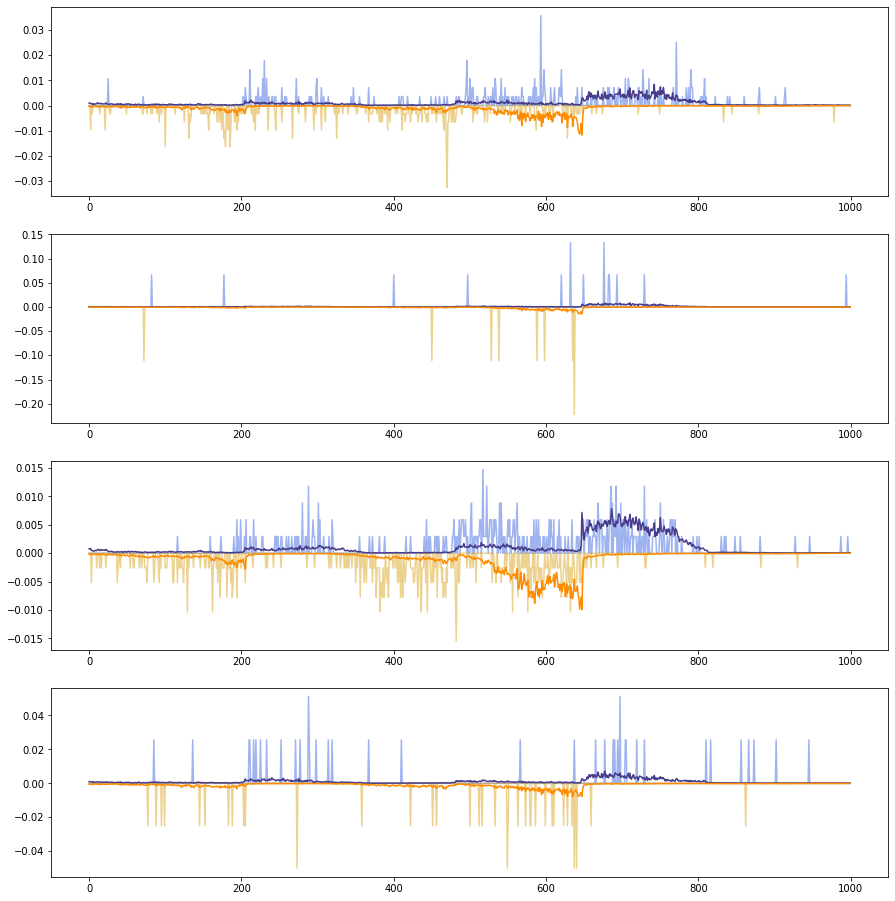

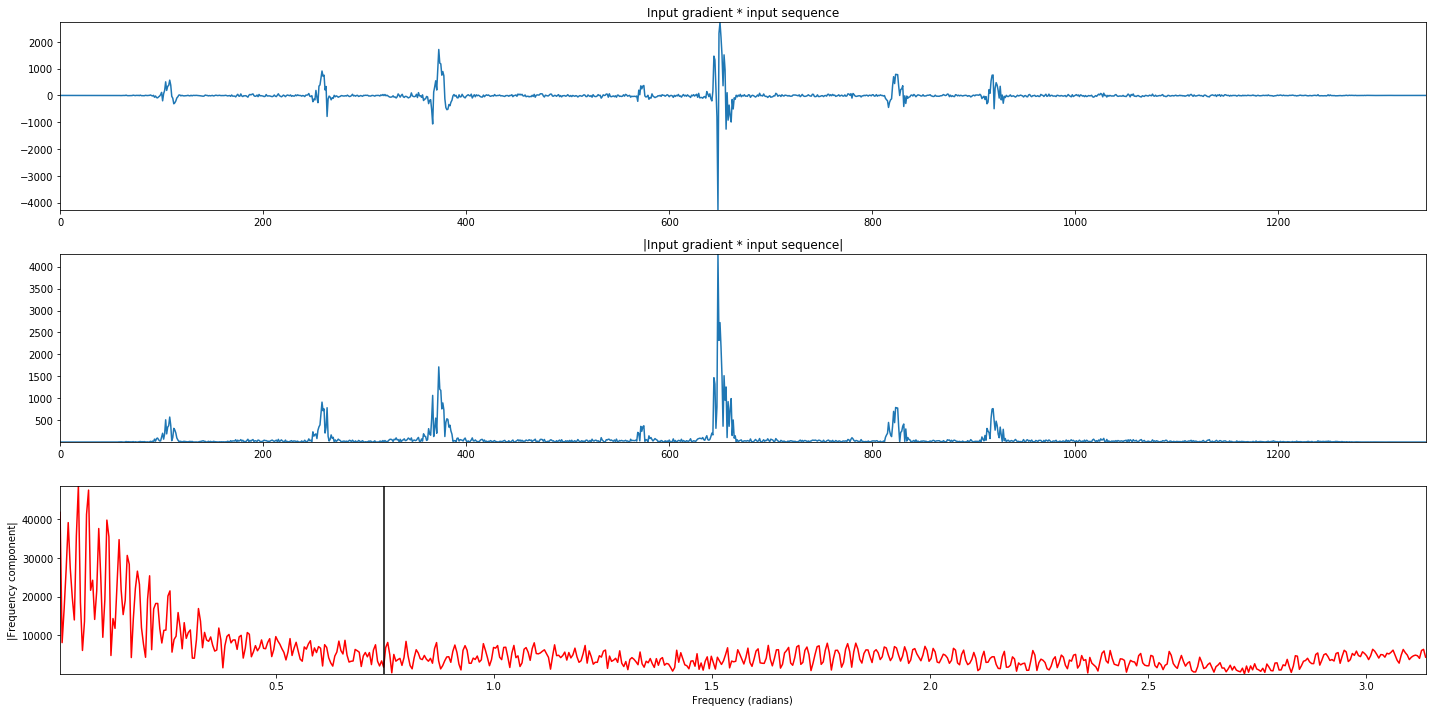

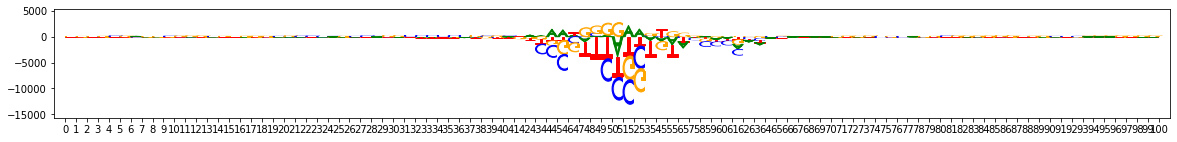

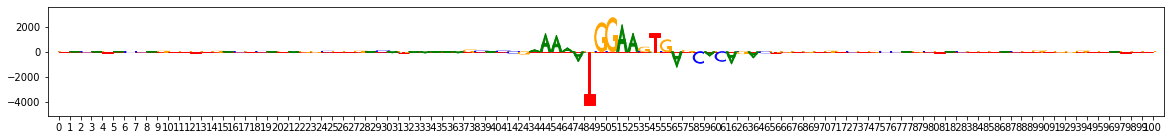

Profile loss	Counts loss	+ prior loss 	-prior loss
420.417	 1.606	 0.404	 0.404


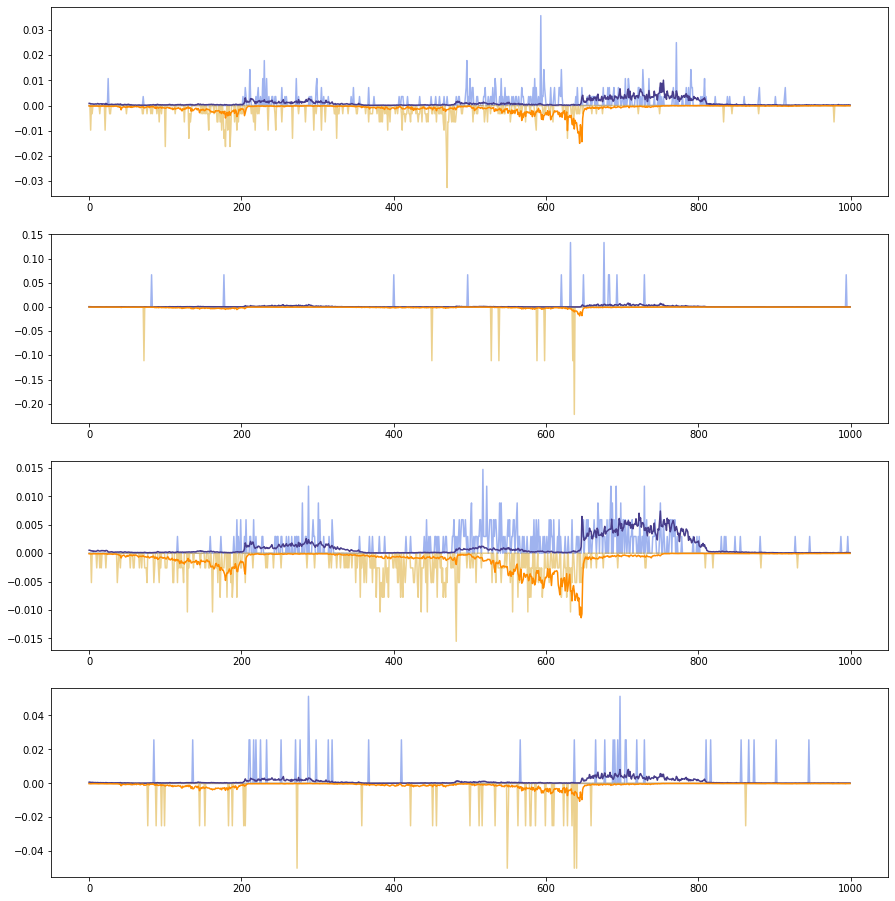

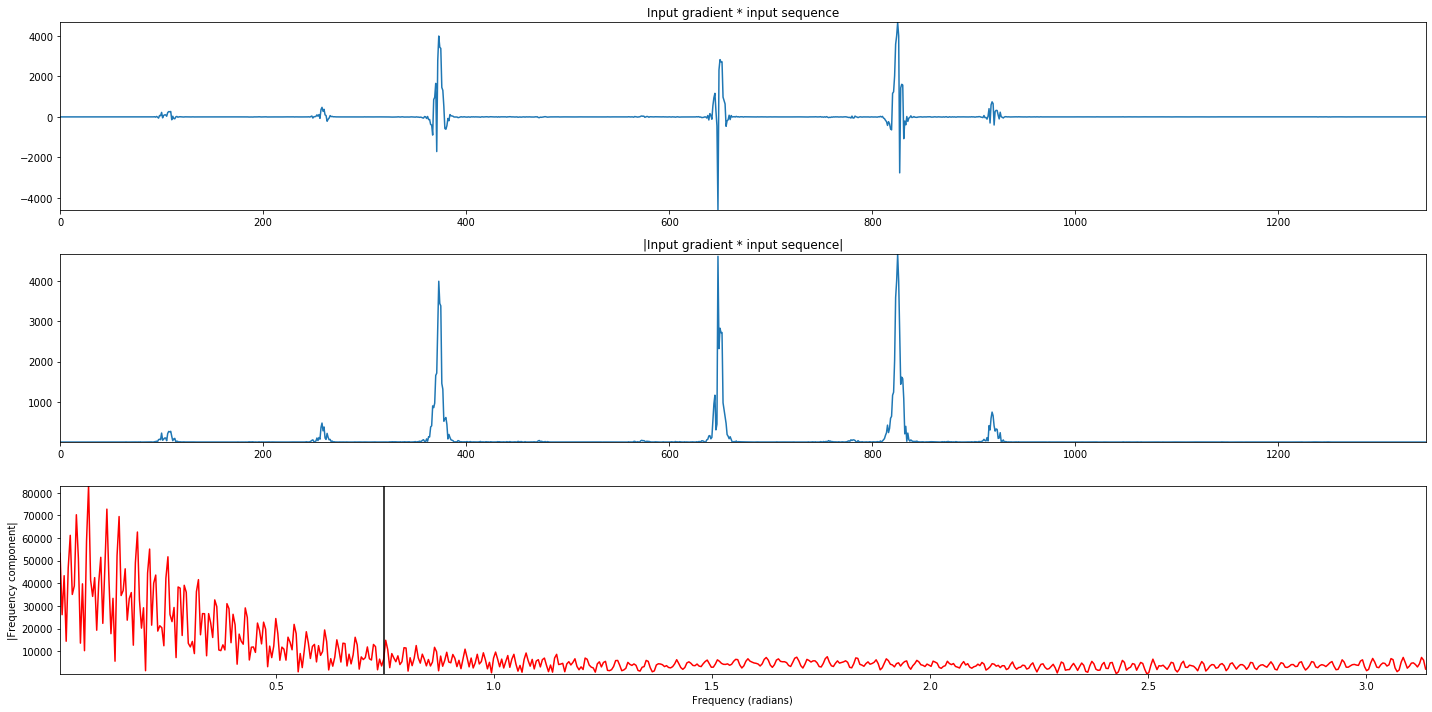

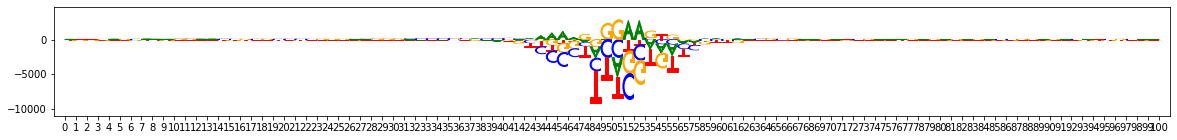

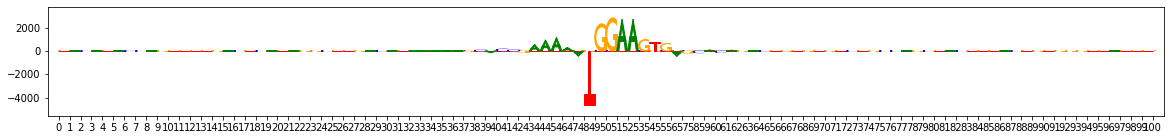

In [28]:
chrom, start, end = "chr8", 81001549, 81001766
predict_and_plot(noprior_model, chrom, start, end)
predict_and_plot(prior_model, chrom, start, end)

Profile loss	Counts loss	+ prior loss 	-prior loss
457.341	 1.065	 0.897	 0.897


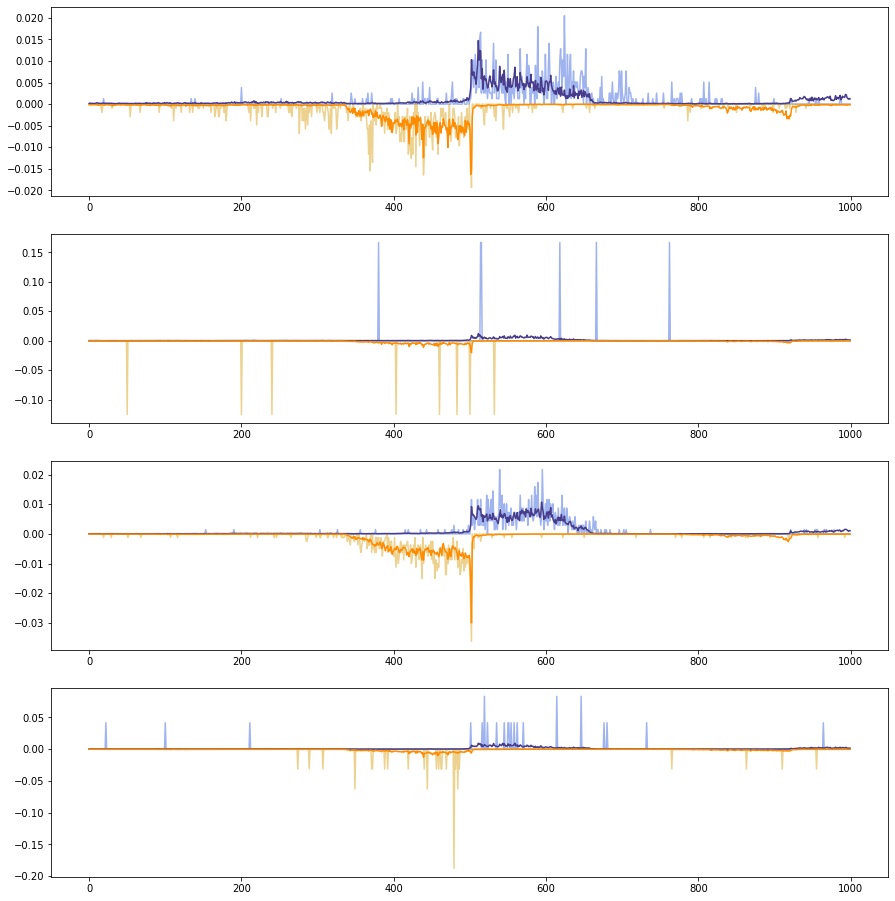

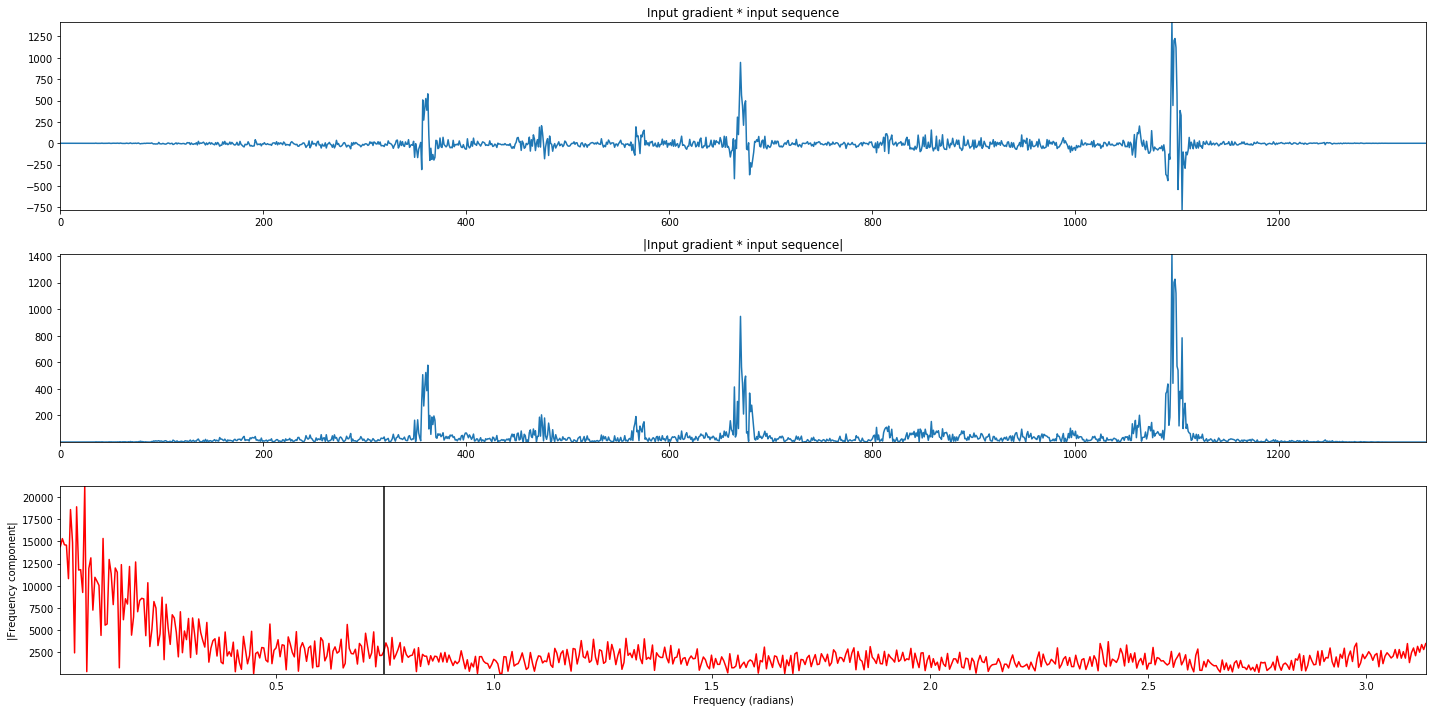

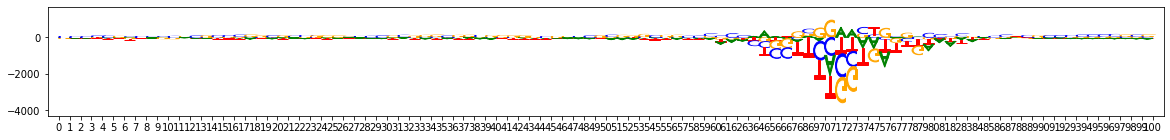

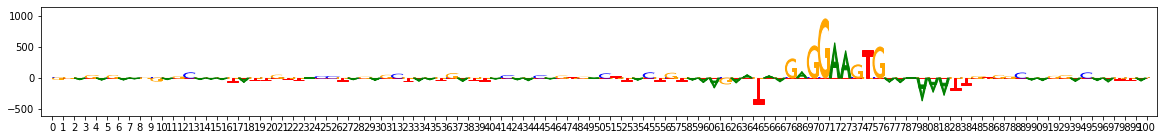

Profile loss	Counts loss	+ prior loss 	-prior loss
445.588	 0.468	 0.386	 0.386


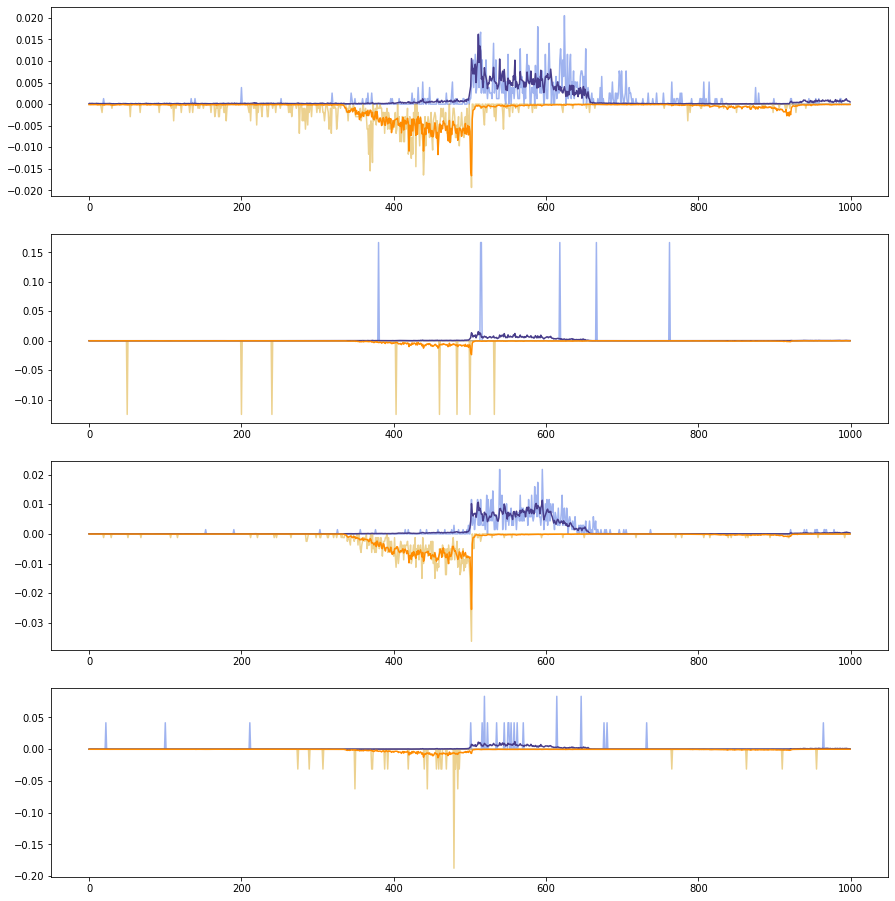

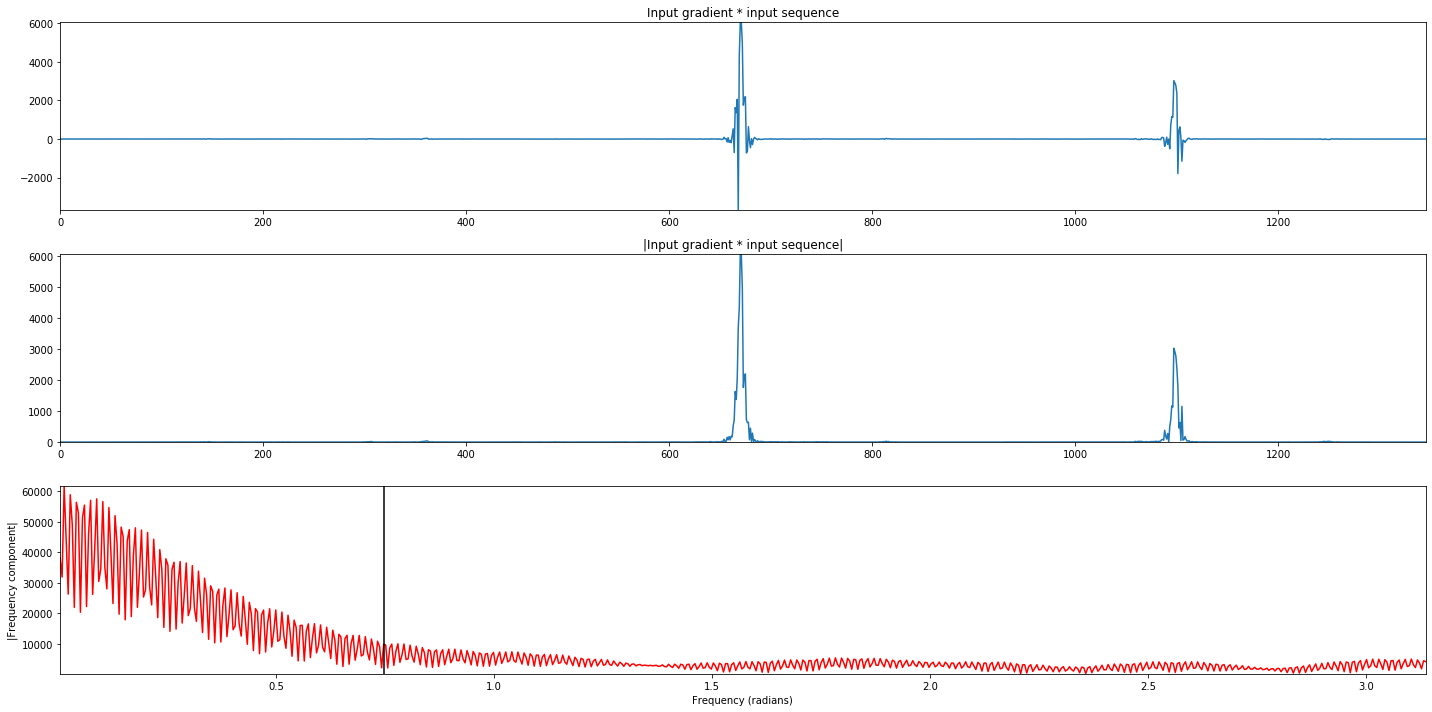

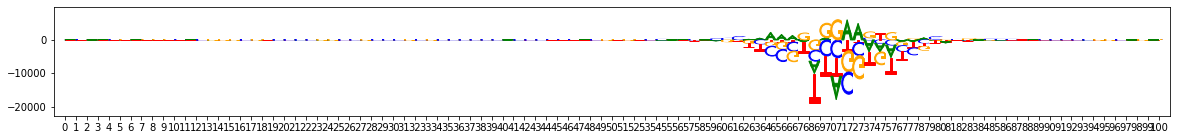

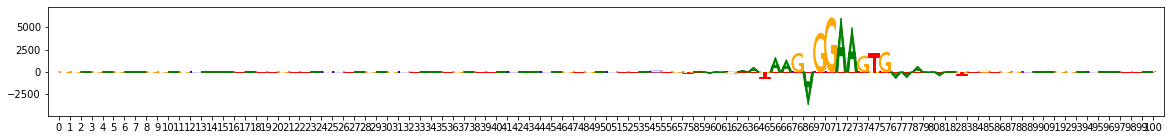

In [29]:
chrom, start, end = "chr8", 118499246, 118499551
predict_and_plot(noprior_model, chrom, start, end)
predict_and_plot(prior_model, chrom, start, end)

Profile loss	Counts loss	+ prior loss 	-prior loss
204.231	 0.936	 0.219	 0.000


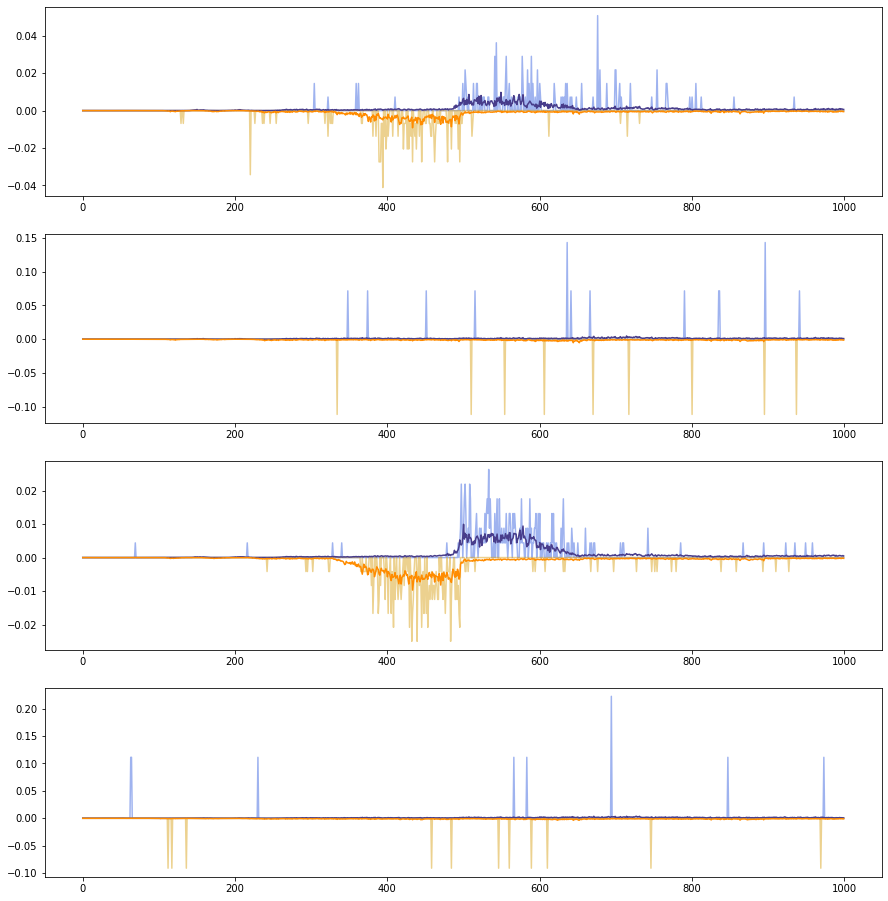

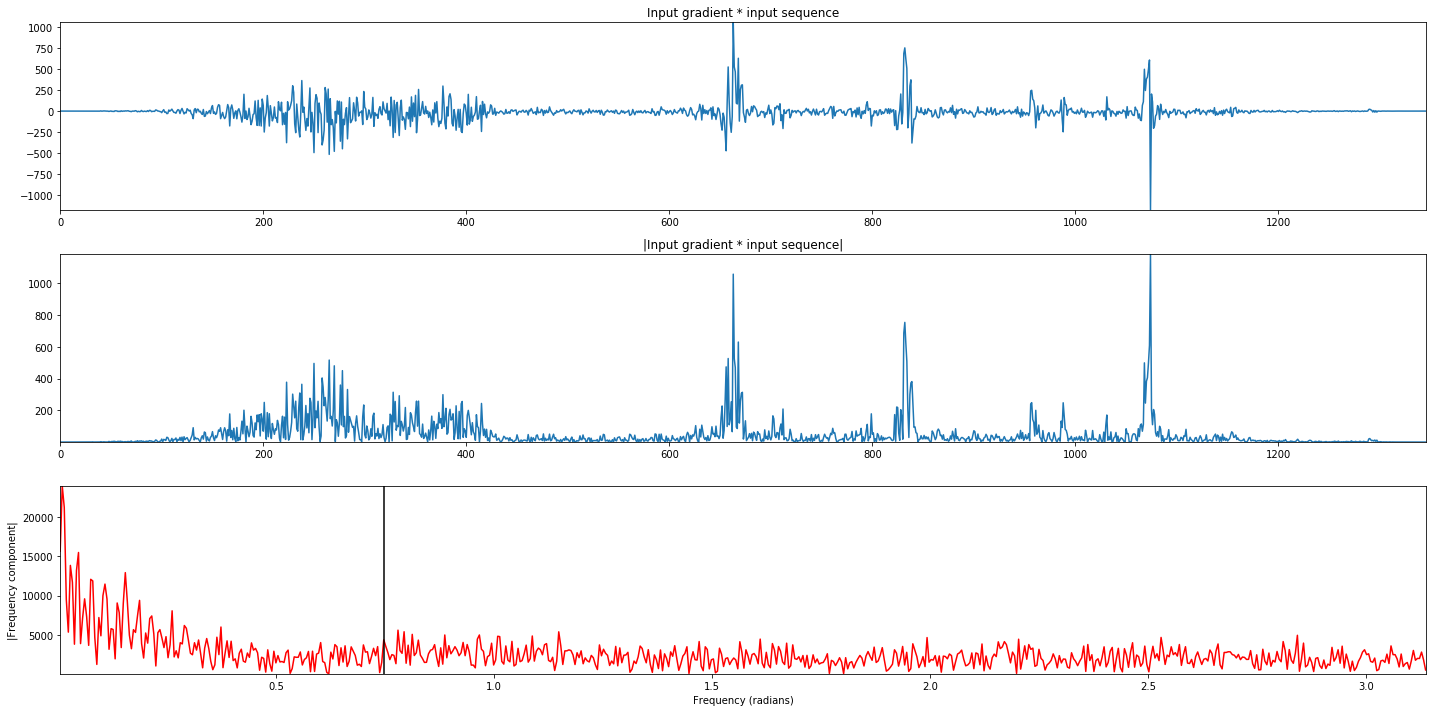

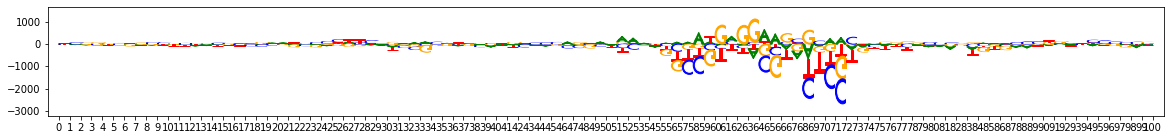

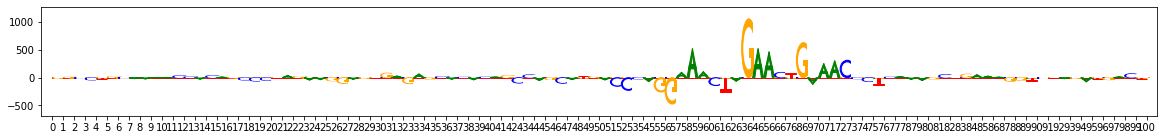

Profile loss	Counts loss	+ prior loss 	-prior loss
235.458	 1.976	 0.086	 0.000


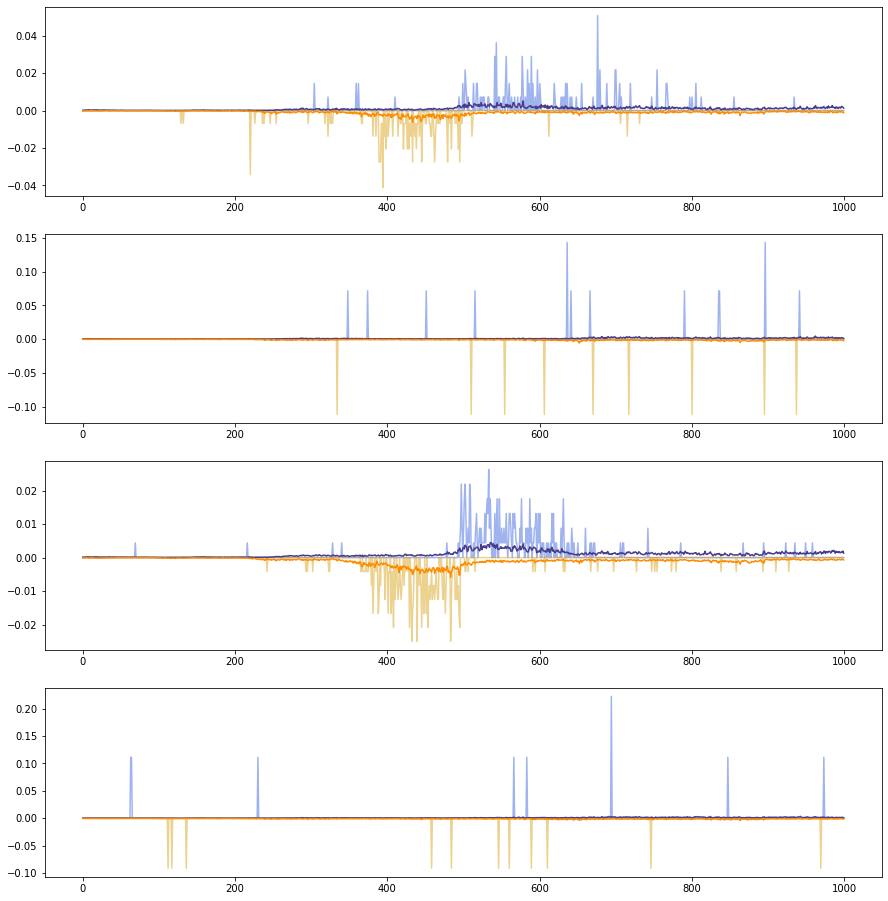

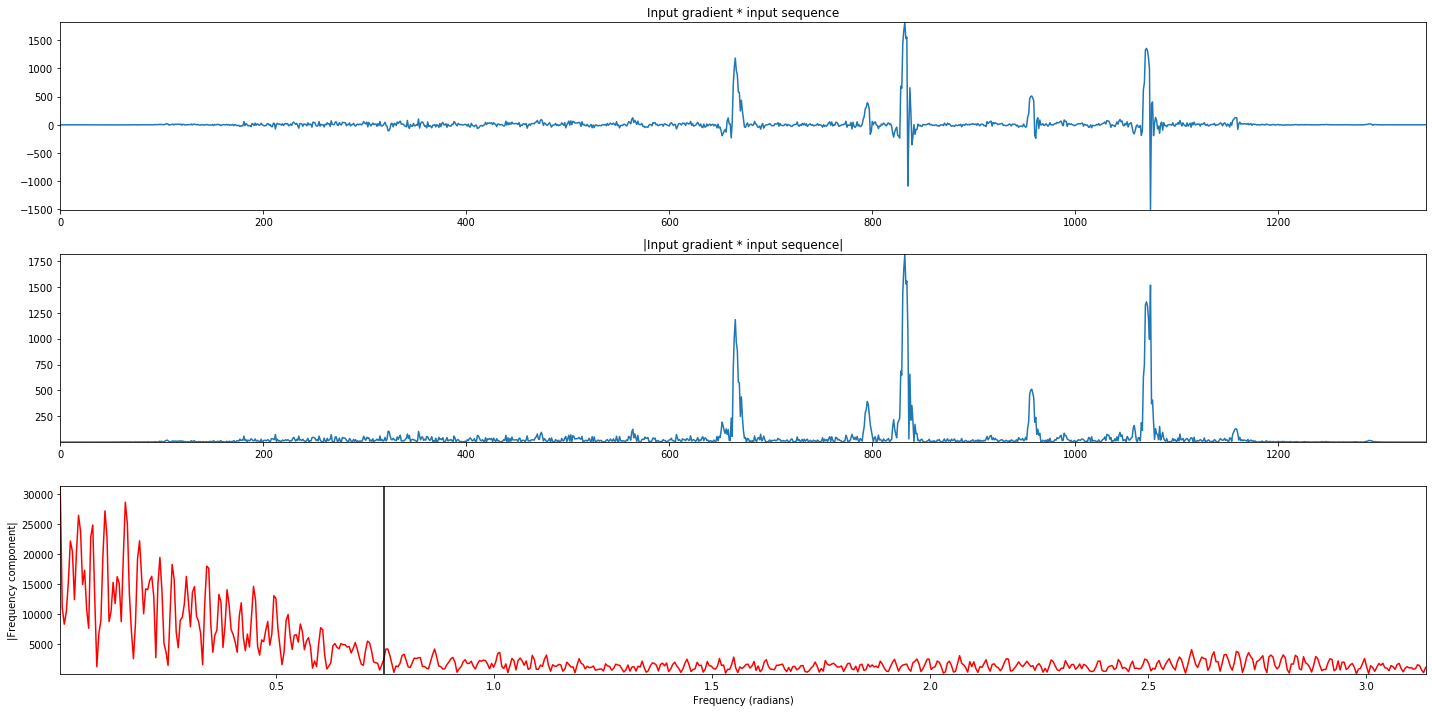

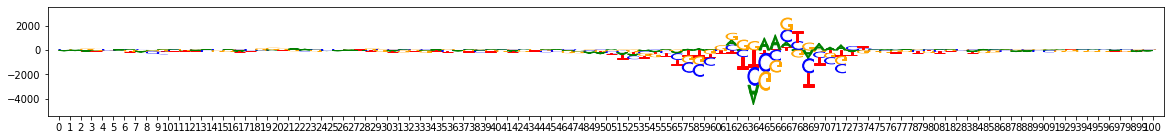

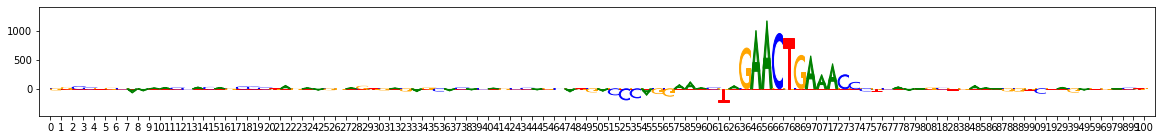

In [22]:
chrom, start, end = "chr10", 71873725, 71873886
predict_and_plot(noprior_model, chrom, start, end)
predict_and_plot(prior_model, chrom, start, end)

Profile loss	Counts loss	+ prior loss 	-prior loss
150.649	 0.760	 0.146	 0.000


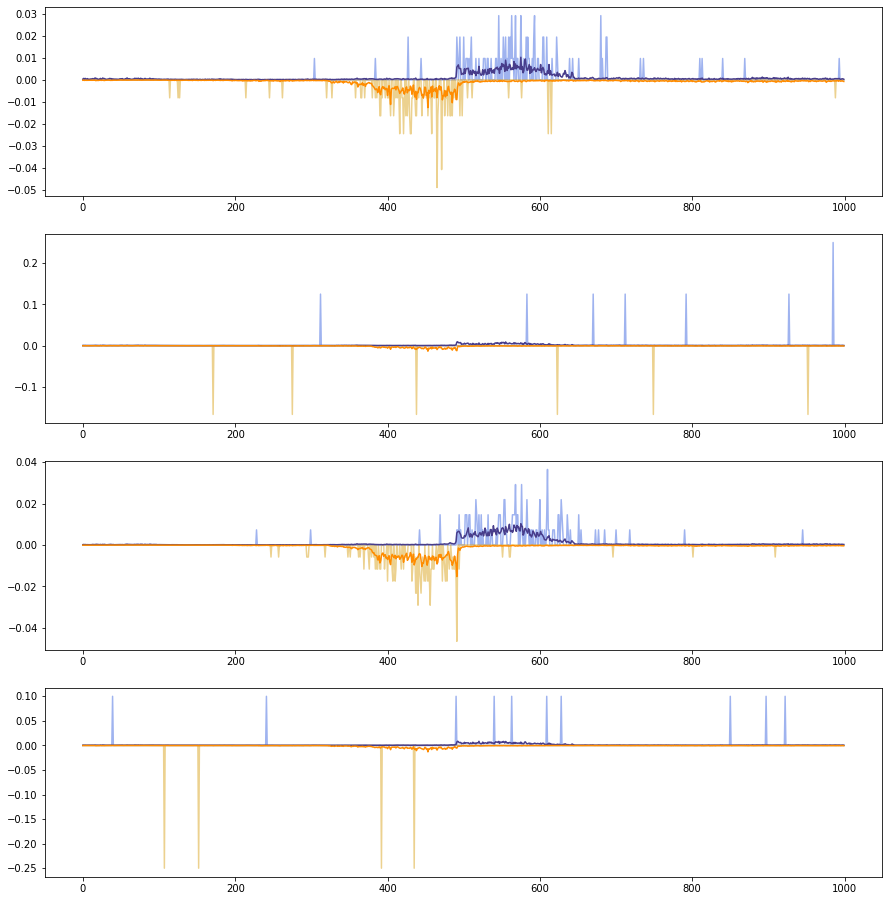

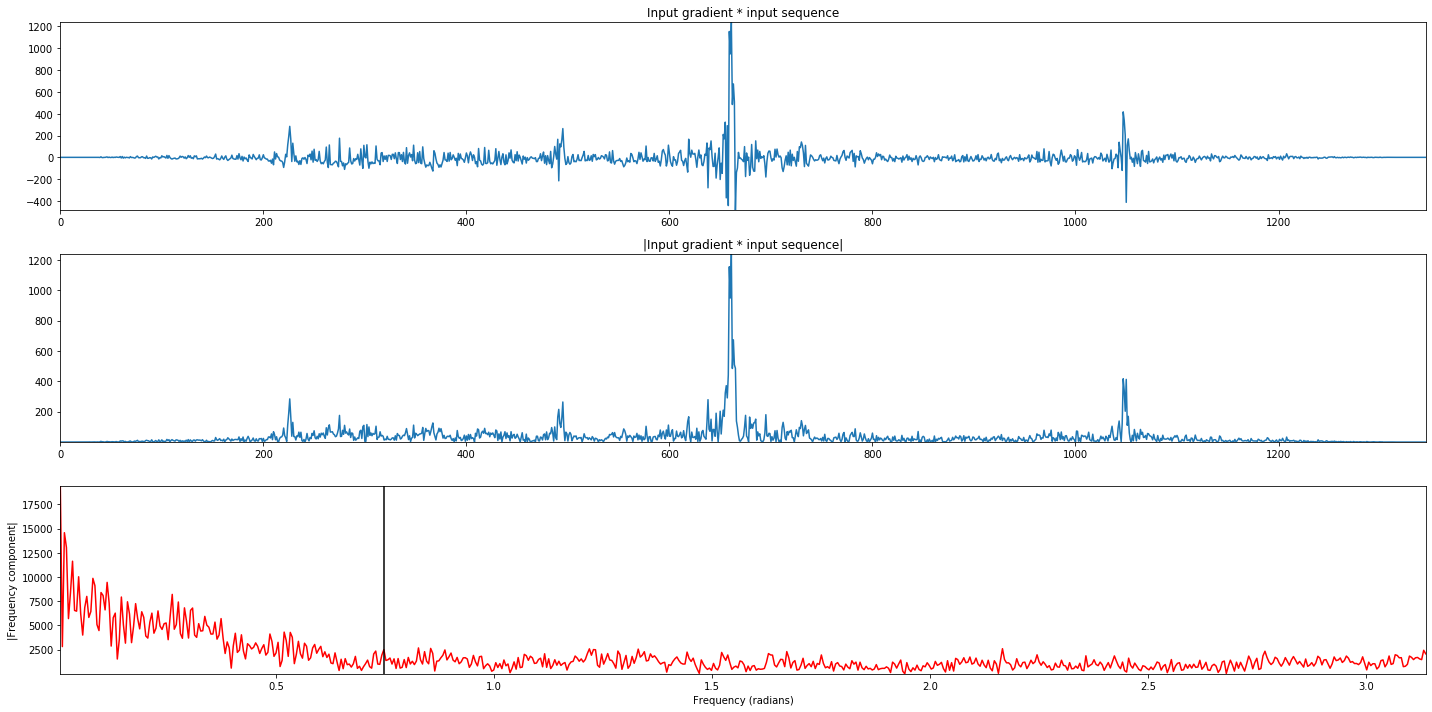

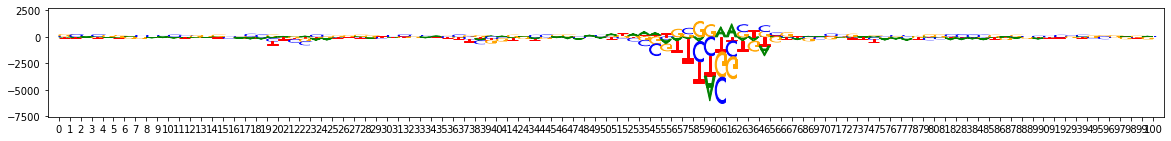

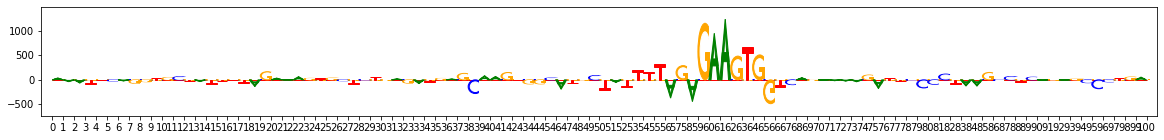

Profile loss	Counts loss	+ prior loss 	-prior loss
177.396	 1.879	 0.052	 0.000


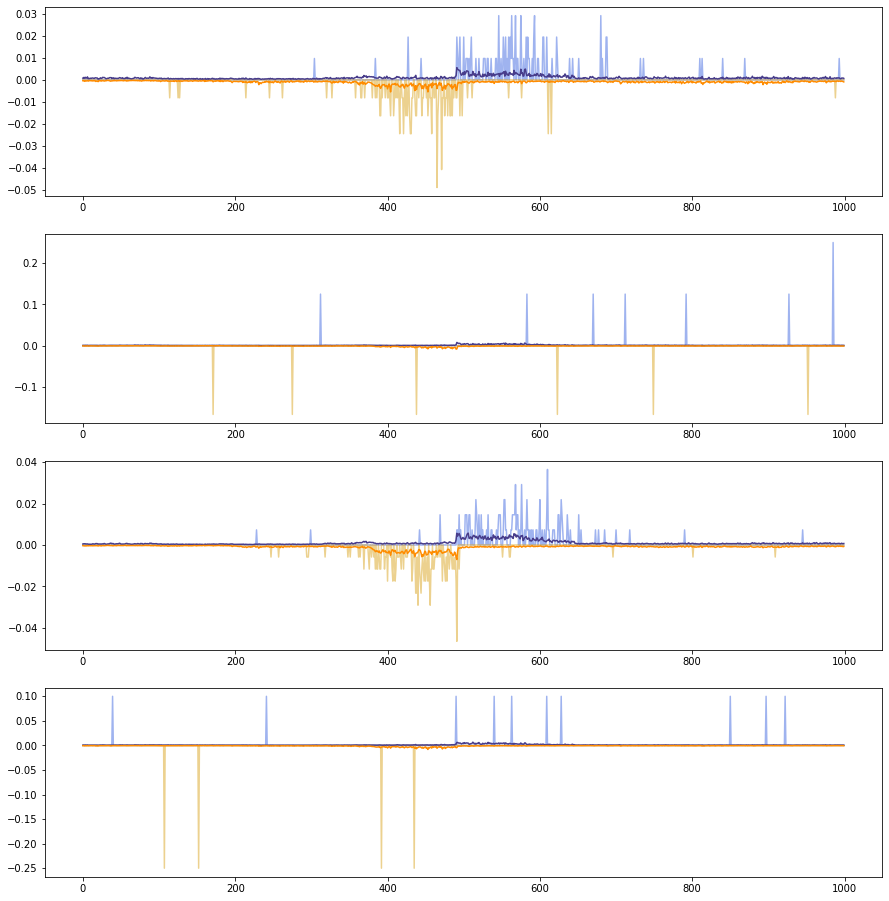

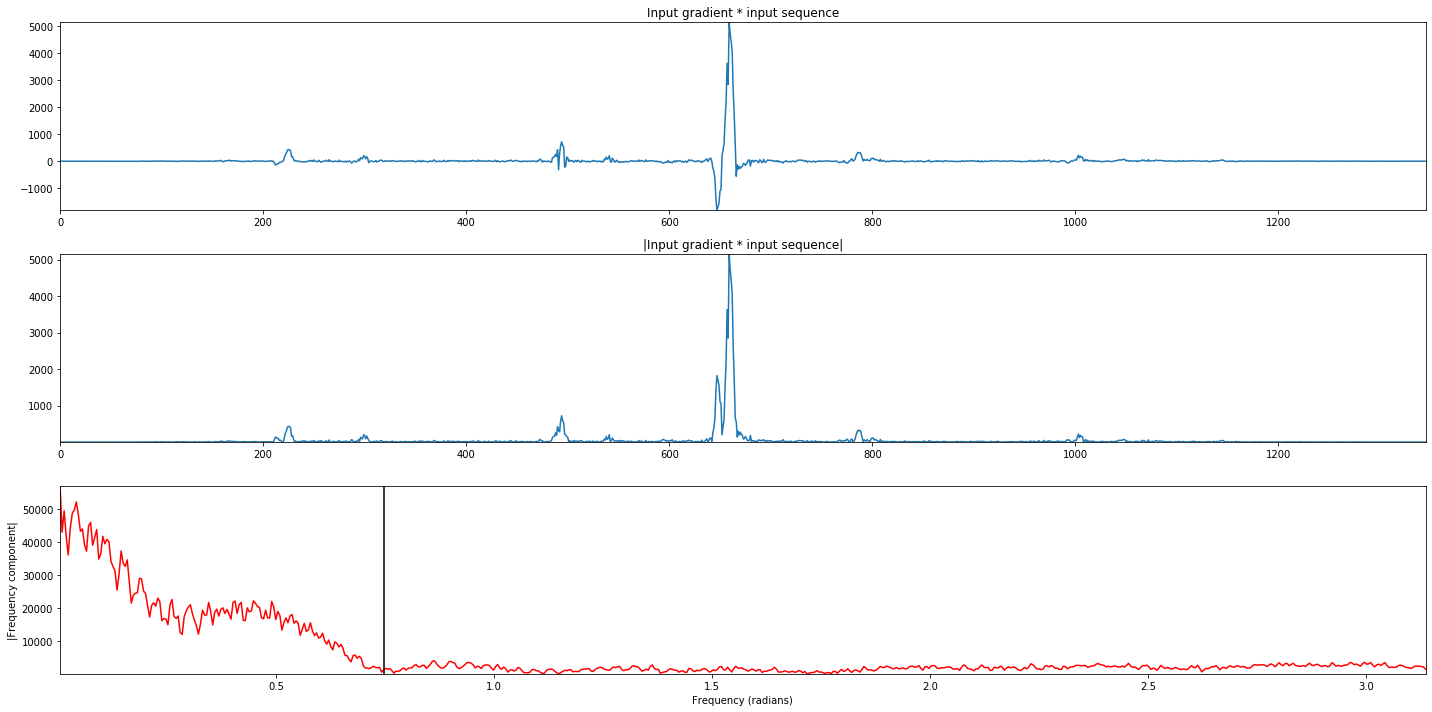

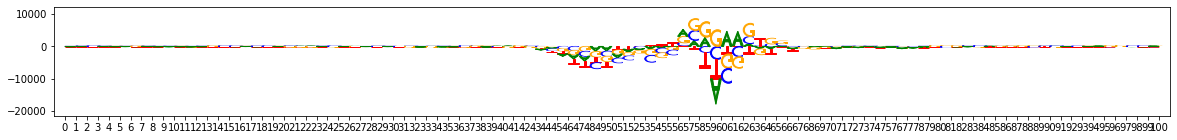

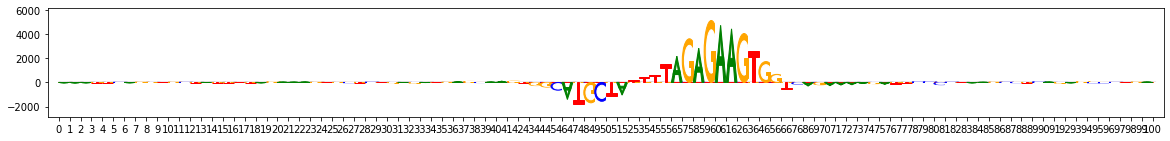

In [23]:
chrom, start, end = "chr8", 127422302, 127422470
predict_and_plot(noprior_model, chrom, start, end)
predict_and_plot(prior_model, chrom, start, end)